In [1]:
version()

'SageMath version 9.2, Release Date: 2020-10-24'

In [2]:
#%display latex

# Definición de la variedad e introducción de carta
Lo primero que vamos a necesitar es definir de forma adecuada la variedad que representa el espacio de fase sobre el que definiremos la mecánica que vamos a estudiar y introducir sobre esta cartas apropiadas. 

In [3]:
n = 3 #cantidad de grados de libertad
M=Manifold(2*n, name='M', structure="differentiable"); M

6-dimensional differentiable manifold M

Por el momento el problema solo lo hemos formulado en coordenadas cartesianas (en el espacio físico), por lo que usamos las coordenadas canónica inducidas por estas sobre M. Recordemos que M es el espacio cotangente de la variedad de configuraciones, que para el problema de Kepler puede representarse como $\mathbb{R^3}/{0}$. 

In [4]:
std.<x, y, z, px, py, pz> = M.chart('x y z px:p_x py:p_y pz:p_z', coord_restrictions= lambda x,y,z,px,py,pz :x**2 + y**2 + z**2 !=0); std

In [5]:
latex(M.default_frame()) #base de vectores 

\left(M, \left(\frac{\partial}{\partial x },\frac{\partial}{\partial y },\frac{\partial}{\partial z },\frac{\partial}{\partial {p_x} },\frac{\partial}{\partial {p_y} },\frac{\partial}{\partial {p_z} }\right)\right)

In [6]:
##Notese que estamos restringiendo la carta para que no considere el origen y también le pasamos la restricción
##a sage para la manipulación simbólica. 
(x**2 + y**2+z**2>0).assume()  
assumptions()              

[x is real,
 y is real,
 z is real,
 px is real,
 py is real,
 pz is real,
 x^2 + y^2 + z^2 > 0]

# Integradores simplécticos 

La técnica que vamos a usar es llamada _Hamiltonian Splitting_, consiste en dividir el Hamiltoniano en varios Hamiltonianos cuyos flows puedan ser calculados de manera exacta y después componer los flows para aproximar el flow del Hamiltoniano inicial. Para nuestro caso:

$$
H(\mathbf{q},\mathbf{p}) = H_T(\mathbf{p}) + H_V(\mathbf{q})
$$
Para nuestro caso el hamiltoniano es 
$$H(\mathbf{q},\mathbf{p}) = \frac{1}{2}\bigg( p_x^2 + p_y^2 + p_z^2\bigg) - \frac{1}{\sqrt{x^2 + y^2 + z^2}}$$
donde el modelo ya ha sido normalizado. 
$$H_T = \frac{1}{2}\bigg( p_x^2 + p_y^2 + p_z^2\bigg)$$
$$H_V = - \frac{1}{\sqrt{x^2 + y^2 + z^2}}$$
Nuestra siguiente tarea entonces es obtener los flujos de $H_V$ y$H_T$, el primer paso para esto es construir el campo vectorial asoaciado con cada Hamiltoniano.

## Definición de $H_V$ y $H_T$ en Sage
Sagemanifolds permite la introducción de campos escalares sobre las variedades, esto es lo que usamos para definir los Hamiltonianos en que hemos divivido el problema.

In [7]:
H_V = M.scalar_field(-1/sqrt(x**2 + y**2 + z**2), name=r'H_V')
H_T = M.scalar_field( (px^2 +py^2 + pz^2 )/2  , name='H_T' )

In [8]:
H_T.display()

H_T: M --> R
   (x, y, z, px, py, pz) |--> 1/2*px^2 + 1/2*py^2 + 1/2*pz^2

In [9]:
H_V.display()

H_V: M --> R
   (x, y, z, px, py, pz) |--> -1/sqrt(x^2 + y^2 + z^2)

In [10]:
H = H_V + H_T
H.display()

H_V+H_T: M --> R
   (x, y, z, px, py, pz) |--> 1/2*((px^2 + py^2 + pz^2)*sqrt(x^2 + y^2 + z^2) - 2)/sqrt(x^2 + y^2 + z^2)

## Campos Vectoriales Hamiltonianos $X_T$ y $X_V$
Para calcular el flujo usamos el campo vectorial hamiltoniano asociado. Recordemos que tenemos el siguiente isomorfismo ($\omega^{\sharp}$ se ve muy feo entonces lo pongo como $\beta$)
$$
\begin{align*}
  \beta \colon TM & \longrightarrow T^{*}M \\
  a_\alpha \frac{\partial}{\partial q_\alpha} +  b_\alpha \frac{\partial}{\partial p_\alpha} & \longmapsto 
  -b_\alpha dq_\alpha + a_\alpha dp_\alpha
\end{align*}
$$
el cual es facilmente invertible para que nos de la conexión entre los diferenciales de $H_V$ y $H_T$ con sus respectivos campos vectoriales hamiltonianos, los cuales después usaremos para obtener los flows de cada uno.
$$
\begin{align*}
  \beta^{-1} \colon T^{*}M & \longrightarrow TM \\
  a_\alpha dq_\alpha + b_\alpha dp_\alpha & \longmapsto b_\alpha \frac{\partial}{\partial q_\alpha}- a_\alpha \frac{\partial}{\partial p_\alpha}
  \end{align*}
$$
Pasamos ahora a definir $\beta^{-1}$ en Sage con el nombre de beta_inverse 

In [11]:
'''Función que recibe una 1-forma(diferencial) y retorna un campo vectorial. El campo es definido en el frame por 
    defecto de la variedad M sobre la que está definida la forma.
INPUT: (forma diferencial en sagemanifolds) forma diferencial alpha
OUTPUT: (campo vectorial en sagemanifolds) campo vectorial X_alpha'''
def beta_inverse(alpha):
    M = alpha.domain()
    e = M.default_frame()
    ##hasta donde revisé, no hay una forma más simple de acceder a los componentes de la forma.
    ##Me faltó revisar la documentación de campos tensoriales, a lo mejor allá hablan algo de eso.
    #OJO: Se asume que la variedad es de dimensión par y el marco por defecto es la base canónica.
    n= M.dimension()
    X_alpha_q = sum(alpha(e[i+n/2])*e[i] for i in range(0,n/2))
    X_alpha_p = sum(-alpha(e[i])*e[i+n/2] for i in range(0,n/2))
    X_alpha = X_alpha_q + X_alpha_p
    return X_alpha

Procedemos a hacer el cálculo del diferencial de los hamiltonianos y se obtienen los campos vectoriales atravez de $\beta^{-1}$.

In [12]:
dH_V = H_V.differential()
dH_T = H_T.differential()

In [13]:
dH_V.display()

dH_V = x/(x^2 + y^2 + z^2)^(3/2) dx + y/(x^2 + y^2 + z^2)^(3/2) dy + z/(x^2 + y^2 + z^2)^(3/2) dz

In [14]:
dH_T.display()

dH_T = px dpx + py dpy + pz dpz

In [15]:
type(dH_T)

<class 'sage.manifolds.differentiable.diff_form_module.DiffFormFreeModule_with_category.element_class'>

In [16]:
X_T = beta_inverse(dH_T)
X_V = beta_inverse(dH_V)

In [17]:
X_T.display()

dH_T(d/dpx)*d/dx+dH_T(d/dpy)*d/dy+dH_T(d/dpz)*d/dz+-dH_T(d/dx)*d/dpx+-dH_T(d/dy)*d/dpy+-dH_T(d/dz)*d/dpz = px d/dx + py d/dy + pz d/dz

In [18]:
X_V.display()

dH_V(d/dpx)*d/dx+dH_V(d/dpy)*d/dy+dH_V(d/dpz)*d/dz+-dH_V(d/dx)*d/dpx+-dH_V(d/dy)*d/dpy+-dH_V(d/dz)*d/dpz = -x/(x^2 + y^2 + z^2)^(3/2) d/dpx - y/(x^2 + y^2 + z^2)^(3/2) d/dpy - z/(x^2 + y^2 + z^2)^(3/2) d/dpz

In [19]:
X_T[1].expr()

py

Aplicando las ecuaciones de Hamilton podemos dar una respuesta general para la forma de los flows:
$$\psi_{H_T}^{\Delta t} (q,p) = \bigg(q + \frac{\partial H_T}{\partial p}(p) \Delta t, p \bigg) $$
$$\psi_{H_V}^{\Delta t} (q,p) = \bigg(q , p  -\frac{\partial H_V}{\partial q}(q)  \Delta t\bigg) $$
Donde las derivadas parciales (con signo incluido) de los Hamiltonianos provienen de las componentes no nulas de sus campos vectoriales.

# Método Euler simpléctico y definición de los flujos en Sage
Este esquema de aproximación consiste en sencillamente combinar los flujos de $H_V$ y $H_T$ y es de primer orden [see, Munro]. Para nuestra suerte los flujos siempre se pueden obtener sin tener que resolver numéricamente (este era el punto de escoger T(p) + H(q)), pasamos ahora a escribirlos usando las componentes de los campos vectoriales:

$$\psi_{H_T}^{\Delta t} (q,p) = (x + p_x\Delta t, y + p_y\Delta t, z + p_z\Delta t , p_x, p_y,p_z) $$
Este siempre tendrá esta forma si $H_T$ dependen solo de $p$ y además es una forma cuadrática diagonal.
$$\psi_{H_V}^{\Delta t} (q,p) = (x, y,z, p_x - \frac{x\Delta t}{(x^2+y^2+z^2)^{3/2}}, p_y - \frac{y\Delta t}{(x^2+y^2+z^2)^{3/2}} , p_z - \frac{z\Delta t}{(x^2+y^2+z^2)^{3/2}}) $$
Lo siguiente es componerlos, aunque primero debemos de definirlos en Sage para componerlos de forma computacional.



In [20]:
dt = var('dt', latex_name = r'\Delta t')
Psi_T = M.diff_map(M, [x + X_T[0].expr() * dt , y + X_T[1].expr() * dt, z + X_T[2].expr()* dt ,
                       px , py , pz], latex_name=r"\psi_{H_T}^{\Delta t}")
Psi_T.display()

M --> M
   (x, y, z, px, py, pz) |--> (dt*px + x, dt*py + y, dt*pz + z, px, py, pz)

In [21]:
Psi_V = M.diff_map(M, [x, y, z,  X_V[3].expr()*dt + px,
                       X_V[4].expr()*dt + py, X_V[5].expr()*dt + pz], 
                       latex_name=r"\psi_{H_V}^{\Delta t}")
Psi_V.display()

M --> M
   (x, y, z, px, py, pz) |--> (x, y, z, px - dt*x/(x^2 + y^2 + z^2)^(3/2), py - dt*y/(x^2 + y^2 + z^2)^(3/2), pz - dt*z/(x^2 + y^2 + z^2)^(3/2))

### Composición
En principio no hay un motivo para preferir un orden particular de composición en el método de Euler, lo único de lo que podemos estar seguros es de que en general no conmutan ya que las exponenciales de las que provienen los flujos no lo hacen [see, Munro]. Por este motivo exploramos ambos ordenes.

In [22]:
Psi1 = Psi_T * Psi_V
Psi1.display(std)

M --> M
   (x, y, z, px, py, pz) |--> (-(dt^2*x - (dt*px*x^2 + x^3 + (dt*px + x)*y^2 + (dt*px + x)*z^2)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2), -(dt^2*y - (dt*py*x^2 + dt*py*y^2 + x^2*y + y^3 + (dt*py + y)*z^2)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2), -(dt^2*z - (dt*pz*x^2 + dt*pz*y^2 + dt*pz*z^2 + z^3 + (x^2 + y^2)*z)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2), -(dt*x - (px*x^2 + px*y^2 + px*z^2)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2), -(dt*y - (py*x^2 + py*y^2 + py*z^2)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2), -(dt*z - (pz*x^2 + pz*y^2 + pz*z^2)*sqrt(x^2 + y^2 + z^2))/(x^2 + y^2 + z^2)^(3/2))

In [23]:
Psi2 = Psi_V * Psi_T
Psi2.display(std)

M --> M
   (x, y, z, px, py, pz) |--> (dt*px + x, dt*py + y, dt*pz + z, -(dt^2*px + dt*x - (dt^2*px^3 + dt^2*px*py^2 + dt^2*px*pz^2 + 2*dt*px^2*x + 2*dt*px*py*y + 2*dt*px*pz*z + px*x^2 + px*y^2 + px*z^2)*sqrt(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*py*y + 2*dt*pz*z + x^2 + y^2 + z^2))/(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*py*y + 2*dt*pz*z + x^2 + y^2 + z^2)^(3/2), -(dt^2*py + dt*y - (dt^2*px^2*py + dt^2*py^3 + dt^2*py*pz^2 + 2*dt*px*py*x + 2*dt*py^2*y + 2*dt*py*pz*z + py*x^2 + py*y^2 + py*z^2)*sqrt(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*py*y + 2*dt*pz*z + x^2 + y^2 + z^2))/(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*py*y + 2*dt*pz*z + x^2 + y^2 + z^2)^(3/2), -(dt^2*pz + dt*z - (dt^2*pz^3 + 2*dt*px*pz*x + 2*dt*py*pz*y + 2*dt*pz^2*z + pz*x^2 + pz*y^2 + pz*z^2 + (dt^2*px^2 + dt^2*py^2)*pz)*sqrt(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*py*y + 2*dt*pz*z + x^2 + y^2 + z^2))/(dt^2*px^2 + dt^2*py^2 + dt^2*pz^2 + 2*dt*px*x + 2*dt*

Se ve que las expresiones obtenidas para $\Psi_1=\Psi_{H_V}^{\Delta t}  \Psi_{H_T}^{\Delta t}$  y $\Psi_2=\Psi_{H_T}^{\Delta t}  \Psi_{H_V}^{\Delta t}$ son apreciablemente diferentes aunque de primer orden, Munro solo considera $\Psi_1$.

Ahora podemos proceder a introducir el método numérico como tal. Por practicidad y para futuras extensiones, es útil introducir una función que construya con fast_callable todas las funciones que necesitamos para usar el método numérico.

In [24]:
'''Función que recibe un mapa diferenciable y produce un grupo de funciones fast_callable que lo evaluan en 
coordenadas.'''
def get_num_funcs(Psi):
    expressions = Psi.expr()
    psi_x = fast_callable(expressions[0], vars=[x,y,z, px, py, pz, dt])
    psi_y = fast_callable(expressions[1], vars=[x,y,z, px, py, pz, dt])
    psi_z = fast_callable(expressions[2], vars=[x,y,z, px, py, pz, dt])
    psi_px = fast_callable(expressions[3], vars=[x,y,z, px, py, pz, dt])
    psi_py = fast_callable(expressions[4], vars=[x,y,z, px, py, pz, dt])
    psi_pz = fast_callable(expressions[5], vars=[x,y,z, px, py, pz,  dt])
    return psi_x, psi_y,psi_z, psi_px, psi_py,psi_pz

In [25]:
#vamos a necesitar numpy y matplotlib para lo que sigue
import numpy as np
import matplotlib.pyplot as plt

## Resultados para $\Psi_1$

In [26]:
#definimos donde vamos a guardar la información  
N = 1000 #pasos
h = 0.001 #tamaño del paso
data_t = np.zeros(N,)
data_x = np.zeros(N,)
data_y = np.zeros(N,) #esto se puede abreviar con un solo array más grande
data_z = np.zeros(N,) 
data_px = np.zeros(N,)
data_py = np.zeros(N,)
data_pz = np.zeros(N,)
data_energy = np.zeros(N,)
data_L = np.zeros(N,)
x0, y0 ,z0, px0, py0,pz0 = 0.3,0,0,0,1,0 #condiciones iniciales
xi0 = M.point((x0,y0,z0,px0,py0,pz0))
E0 = H(xi0) #energía inicial
psi_x, psi_y,psi_z, psi_px, psi_py,psi_pz = get_num_funcs(Psi1) 

In [27]:
#Mostramos el valor de la energía inicial
E0

-2.833333333333333

In [28]:
#añadimos las condiciones iniciales al principio de cada data array
data_x[0] = x0
data_y[0] = y0
data_z[0] = z0
data_px[0] = px0
data_py[0] = py0
data_pz[0] = pz0
data_energy[0] = E0
data_L[0] = py0*x0 -px0*y0

In [29]:
for k in range(1,N): #quizá esto no es la mejor forma de hacer esto pero ajá
    x_k = data_x[k-1]
    y_k = data_y[k-1]
    z_k = data_z[k-1]
    px_k = data_px[k-1]
    py_k = data_py[k-1]
    pz_k = data_pz[k-1]
    
    data_t[k] = k*h 
    data_x[k] = psi_x(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_y[k] = psi_y(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_z[k] = psi_z(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_px[k] = psi_px(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_py[k] = psi_py(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_pz[k] = psi_pz(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    #hay un problema con las conversiones y no me deja llamar directamente la función H en manifolds
    data_energy[k] = 0.5*(data_px[k]**2 + data_py[k]**2 + data_pz[k]**2) - 1/np.sqrt(data_x[k]**2 + data_y[k]**2 + data_z[k]**2)
    data_L[k] = data_x[k]*data_py[k] - data_y[k]*data_px[k]

Text(0.5, 0, '$z$')

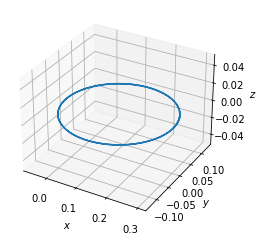

In [30]:
#plt.plot(data_x, data_y)
#plt.xlabel(r"$x$")
#plt.ylabel(r"$y$")
#plt.title(r"Plano $xy$")

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axes.set_xlim3d(-.2, .1)
#ax.axes.set_ylim3d(0, .0001) 
#ax.axes.set_zlim3d(-1, 1) 
ax.plot3D(data_x, data_y,data_z,label='Solución Integrador')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

Text(0.5, 1.0, 'Energía en función del tiempo')

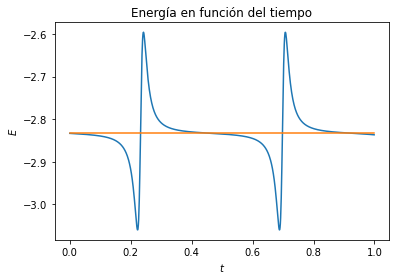

In [31]:
plt.plot(data_t, data_energy)
plt.plot(data_t, np.ones(N,)*data_energy[0])
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.title("Energía en función del tiempo")

Se guardan los valores usando este método:

In [32]:
data_x_e = data_x
data_y_e = data_y
data_z_e = data_z

data_px_e = data_px
data_py_e = data_py
data_pz_e = data_pz

## Resultados para $\Psi_2$

In [33]:
#definimos donde vamos a guardar la información  
N = 1000 #pasos
h = 0.001 #tamaño del paso
data_t = np.zeros(N,)
data_x = np.zeros(N,)
data_y = np.zeros(N,) #esto se puede abreviar con un solo array más grande
data_z = np.zeros(N,) 
data_px = np.zeros(N,)
data_py = np.zeros(N,)
data_pz = np.zeros(N,)
data_energy = np.zeros(N,)
data_L = np.zeros(N,)
x0, y0 ,z0, px0, py0,pz0 = 0.3,0,0,0,1,0 #condiciones iniciales
xi0 = M.point((x0,y0,z0,px0,py0,pz0))
E0 = H(xi0) #energía inicial
psi_x, psi_y,psi_z, psi_px, psi_py,psi_pz = get_num_funcs(Psi2) 

In [34]:
#Mostramos el valor de la energía inicial
E0

-2.833333333333333

In [35]:
#añadimos las condiciones iniciales al principio de cada data array
data_x[0] = x0
data_y[0] = y0
data_z[0] = z0
data_px[0] = px0
data_py[0] = py0
data_pz[0] = pz0
data_energy[0] = E0
data_L[0] = py0*x0 -px0*y0

In [36]:
for k in range(1,N): #quizá esto no es la mejor forma de hacer esto pero ajá
    x_k = data_x[k-1]
    y_k = data_y[k-1]
    z_k = data_z[k-1]
    px_k = data_px[k-1]
    py_k = data_py[k-1]
    pz_k = data_pz[k-1]
    
    data_t[k] = k*h 
    data_x[k] = psi_x(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_y[k] = psi_y(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_z[k] = psi_z(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_px[k] = psi_px(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_py[k] = psi_py(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_pz[k] = psi_pz(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    #hay un problema con las conversiones y no me deja llamar directamente la función H en manifolds
    data_energy[k] = 0.5*(data_px[k]**2 + data_py[k]**2 + data_pz[k]**2) - 1/np.sqrt(data_x[k]**2 + data_y[k]**2 + data_z[k]**2)
    data_L[k] = data_x[k]*data_py[k] - data_y[k]*data_px[k]

Text(0.5, 0, '$z$')

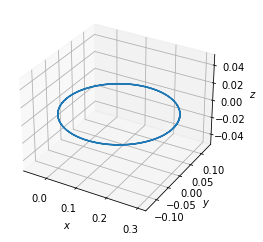

In [37]:
#plt.plot(data_x, data_y)
#plt.xlabel(r"$x$")
#plt.ylabel(r"$y$")
#plt.title(r"Plano $xy$")

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axes.set_xlim3d(-.2, .1)
#ax.axes.set_ylim3d(0, .0001) 
#ax.axes.set_zlim3d(-1, 1) 
ax.plot3D(data_x, data_y,data_z,label='Solución Integrador')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

Vemos que cambiar el orden de integración sí tiene un efecto sobre el comportamiento, ahora la oscilación de la energía está desfazada en medio periodo. 

Nota para Federico: toca mirar bien los motivos de la oscilación para poder analizar mejor porque se invierte.

Text(0.5, 1.0, 'Energía en función del tiempo')

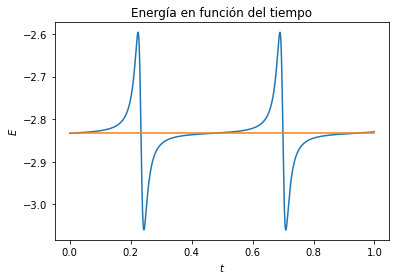

In [38]:
plt.plot(data_t, data_energy)
plt.plot(data_t, np.ones(N,)*data_energy[0])
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.title("Energía en función del tiempo")

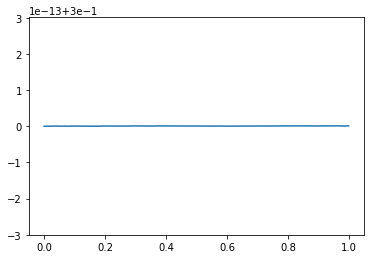

In [39]:
plt.plot(data_t, data_L)

# Stormer - Verlet
$$
  \exp \left( \frac{1}{2} \Delta t X_V \right) \exp \left( \Delta t X_T \right)\exp \left( \frac{1}{2} \Delta t X_V \right)
$$
Para la introducción de este debemos de modificar ligeramente los flujos para dar cuenta de las constantes introducidas.

In [40]:
dt = var('dt', latex_name = r'\Delta t')
Psi_T = M.diff_map(M, [x + X_T[0].expr() * dt , y + X_T[1].expr() * dt, z + X_T[2].expr()* dt ,
                       px , py , pz], latex_name=r"\psi_{H_T}^{\Delta t}")
Psi_T.display()

M --> M
   (x, y, z, px, py, pz) |--> (dt*px + x, dt*py + y, dt*pz + z, px, py, pz)

In [41]:
Psi_V_modified = M.diff_map(M, [x, y, z,  X_V[3].expr()*dt/2 + px, X_V[4].expr()*dt/2 + py, X_V[5].expr()*dt/2 + pz], 
                       latex_name=r"\psi_{H_V}^{\Delta t}")
Psi_V_modified.display()

M --> M
   (x, y, z, px, py, pz) |--> (x, y, z, px - 1/2*dt*x/(x^2 + y^2 + z^2)^(3/2), py - 1/2*dt*y/(x^2 + y^2 + z^2)^(3/2), pz - 1/2*dt*z/(x^2 + y^2 + z^2)^(3/2))

In [42]:
storm_verlet_integrator = Psi_V_modified * Psi_T * Psi_V_modified

In [43]:
#definimos las expresiones mediante fast_callable para que podamos evaluar no solo los puntos sino también dt
expressions = storm_verlet_integrator.expr()
psi_x = fast_callable(expressions[0], vars=[x,y,z, px, py, pz, dt])
psi_y = fast_callable(expressions[1], vars=[x,y,z, px, py, pz, dt])
psi_z = fast_callable(expressions[2], vars=[x,y,z, px, py, pz, dt])
psi_px = fast_callable(expressions[3], vars=[x,y,z, px, py, pz, dt])
psi_py = fast_callable(expressions[4], vars=[x,y,z, px, py, pz, dt])
psi_pz = fast_callable(expressions[5], vars=[x,y,z, px, py, pz,  dt])

In [44]:
#vamos a necesitar numpy y matplotlib para lo que sigue
import numpy as np
import matplotlib.pyplot as plt

In [45]:
#definimos donde vamos a guardar la información 

N = 1000 #pasos
h = 0.001 #tamaño del paso
data_t = np.zeros(N,)
data_x = np.zeros(N,)
data_y = np.zeros(N,) #esto se puede abreviar con un solo array más grande
data_z = np.zeros(N,)
data_px = np.zeros(N,)
data_py = np.zeros(N,)
data_pz = np.zeros(N,)
data_energy = np.zeros(N,)
data_L = np.zeros(N,)
x0, y0, z0, px0, py0,pz0 = 0.3,0,0,0,1,0 #condiciones iniciales
xi0 = M.point((x0,y0,z0,px0,py0,pz0))
E0 = H(xi0) #energía inicial


In [46]:
E0

-2.833333333333333

In [47]:
#añadimos las condiciones iniciales al principio de cada data array
data_x[0] = x0
data_y[0] = y0
data_z[0] = z0
data_px[0] = px0
data_py[0] = py0
data_pz[0] = pz0
data_energy[0] = E0
data_L[0] = x0*py0 - y0*px0

In [48]:
for k in range(1,N): #quizá esto no es la mejor forma de hacer esto pero ajá
    x_k = data_x[k-1]
    y_k = data_y[k-1]
    z_k = data_z[k-1]
    px_k = data_px[k-1]
    py_k = data_py[k-1]
    pz_k = data_pz[k-1]
    
    data_t[k]  = k*h 
    data_x[k]  = psi_x(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_y[k]  = psi_y(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_z[k]  = psi_z(x_k, y_k, z_k ,px_k, py_k,pz_k ,  h)
    data_px[k] = psi_px(x_k, y_k, z_k ,px_k, py_k,pz_k , h)
    data_py[k] = psi_py(x_k, y_k, z_k ,px_k, py_k,pz_k , h)
    data_pz[k] = psi_pz(x_k, y_k, z_k ,px_k, py_k,pz_k , h)
    #hay un problema con las conversiones y no me deja llamar directamente la función H en manifolds
    data_energy[k] = float(0.5*(data_px[k]**2 + data_py[k]**2 + data_pz[k]**2 ) - 1/np.sqrt(data_x[k]**2 + data_y[k]**2 + data_z[k]**2))
    data_L[k] = float(data_x[k]*data_py[k] - data_y[k]*data_px[k])

Text(0.5, 0, '$z$')

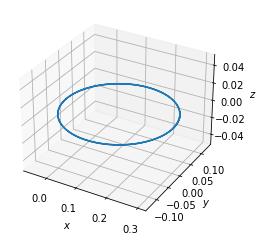

In [49]:
#plt.plot(data_x,data_y)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axes.set_xlim3d(-.2, .1)
#ax.axes.set_ylim3d(0, .0001) 
#ax.axes.set_zlim3d(-1, 1) 
ax.plot3D(data_x, data_y,data_z,label='Solución Integrador')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

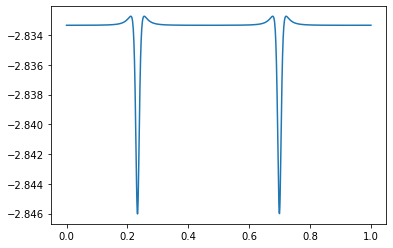

In [50]:
plt.plot(data_t, data_energy)

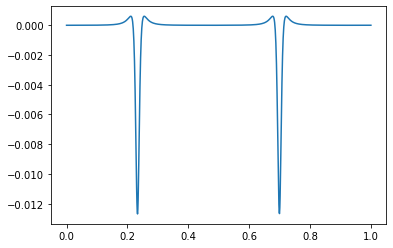

In [51]:
plt.plot(data_t, data_energy - np.ones(N,)*data_energy[0])

In [52]:
type(data_energy[0])

<class 'numpy.float64'>

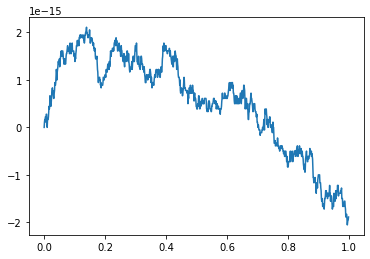

In [53]:
plt.plot(data_t, np.ones(N,)*data_L[0]-data_L)

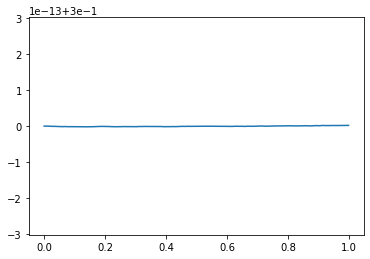

In [54]:
plt.plot(data_t, data_L)

# Cambio de carta y simetrías

Una vez encontrada la solución del flujo usando el integrador se selecciona otra carta para la variedad, y se estudian las simetrías en esta nueva carta.

Se introducen las relaciones de transformación entre cartas:

In [55]:
U = M.open_subset('U', coord_def={std: x^2+y^2+z^2 > 0})
std_U = std.restrict(U)

In [56]:
pol.<r,th,ph,Pr,Pth,Pph> = U.chart(r'r:(0,+oo) th:(0,pi):\theta ph:(0,2*pi):\phi Pr:P_r Pth:P_{\theta} Pph:P_{\phi}')
pol

Chart (U, (r, th, ph, Pr, Pth, Pph))

In [57]:
pol_to_std = pol.transition_map(std_U,[r*sin(th)*cos(ph),
                       r*sin(th)*sin(ph),
                       r*cos(th),
                       Pr*cos(ph)*sin(th)-(Pph*sin(ph))/(r*sin(th)) + (Pth*cos(ph)*cos(th))/r,
                       Pr*sin(ph)*sin(th)+(Pph*cos(ph)/(r*sin(th)) + (Pth*sin(ph)*cos(th))/r),
                       Pr*cos(th) -Pth*sin(th)/r])

pol_to_std.set_inverse(sqrt(x^2+y^2+z^2),
                arctan2(sqrt(x^2+y^2),z),
                arctan2(y,x),
                (x*px+y*py+z*pz)/sqrt(x^2+y^2+z^2),
                -((y^2+x^2)*pz+(-y*py-x*px)*z)/(sqrt(y^2+x^2)),
                ((x*py-y*px)/(x^2 + y^2))*(x^2+y^2+z^2)*sin(arctan2(sqrt(x^2+y^2),z))^2)


Check of the inverse coordinate transformation:
  r == r  *passed*
  th == arctan2(r*sin(th), r*cos(th))  **failed**
  ph == arctan2(r*sin(ph)*sin(th), r*cos(ph)*sin(th))  **failed**
  Pr == Pr  *passed*
  Pth == Pth  *passed*
  Pph == Pph  *passed*
  x == x  *passed*
  y == y  *passed*
  z == z  *passed*
  px == px  *passed*
  py == py  *passed*
  pz == pz  *passed*
NB: a failed report can reflect a mere lack of simplification.


In [58]:
pol_to_std.display()


x = r*cos(ph)*sin(th)
y = r*sin(ph)*sin(th)
z = r*cos(th)
px = Pr*cos(ph)*sin(th) + Pth*cos(ph)*cos(th)/r - Pph*sin(ph)/(r*sin(th))
py = Pr*sin(ph)*sin(th) + Pth*cos(th)*sin(ph)/r + Pph*cos(ph)/(r*sin(th))
pz = Pr*cos(th) - Pth*sin(th)/r

In [59]:
pol_to_std.inverse().display()

r = sqrt(x^2 + y^2 + z^2)
th = arctan2(sqrt(x^2 + y^2), z)
ph = arctan2(y, x)
Pr = (px*x + py*y + pz*z)/sqrt(x^2 + y^2 + z^2)
Pth = -((x^2 + y^2)*pz - (px*x + py*y)*z)/sqrt(x^2 + y^2)
Pph = py*x - px*y

Directamente de la transformación para $P_\phi$, se ve que esta corresponde al momento angular en la coordenada z, $L_z$. Al siempre conservarse esta cantidad en general, la órbita siempre estará ubicada en un plano, por lo cual siempre es posible encontrar una carta donde el movimiento tenga solo 2 grados de libertad.  

Con la forma de las transformaciones se puede encontrar la solución para la carta $\left( U , (r, \theta, \phi , P_r , P_{\theta}, P_{\Phi}) \right)$:

Para la solución encontrada por el método Euler Simpléctico:

In [60]:
data_r_e = np.sqrt(data_x_e**2 + data_y_e**2 + data_z_e**2 )
data_th_e = np.arctan2(np.sqrt(data_x_e**2 + data_y_e**2),data_z_e)
data_ph_e = np.arctan2(data_y_e,data_x_e)

data_Pr_e = (data_px_e*data_x_e + data_py_e*data_y_e + data_pz_e*data_z_e )/data_r_e
data_Pth_e = ((data_px_e*data_x_e + data_py_e*data_y_e)*data_z_e - (data_x_e**2 + data_y_e**2)*data_pz_e )/(np.sqrt(data_x_e**2 + data_y_e**2))
data_Pph_e = data_py_e*data_x_e - data_y_e*data_px_e

Para la solución del método Stormer - Verlet:

In [61]:
data_r = np.sqrt(data_x**2 + data_y**2 + data_z**2 )
data_th = np.arctan2(np.sqrt(data_x**2 + data_y**2),data_z)
data_ph = np.arctan2(data_y,data_x)

data_Pr = (data_px*data_x + data_py*data_y + data_pz*data_z )/data_r
data_Pth = ((data_px*data_x + data_py*data_y)*data_z - (data_x**2 + data_y**2)*data_pz )/(np.sqrt(data_x**2 + data_y**2))
data_Pph = data_py*data_x - data_y*data_px

Se puede obtener la gráfica del radio $r$ en función de el ángulo azimutal $\phi$:

En la literatura se puede encontrar la conocida relación $r (\phi) = \frac{L^2_z}{1 -e\cos{\phi}}$, donde $e= \sqrt{1+2EL^2_z}$.

La gráfica inferior muestra las curvas obtenidas, donde la línea negra corresponde a la solución analítica del problema.

<IPython.core.display.Javascript object>


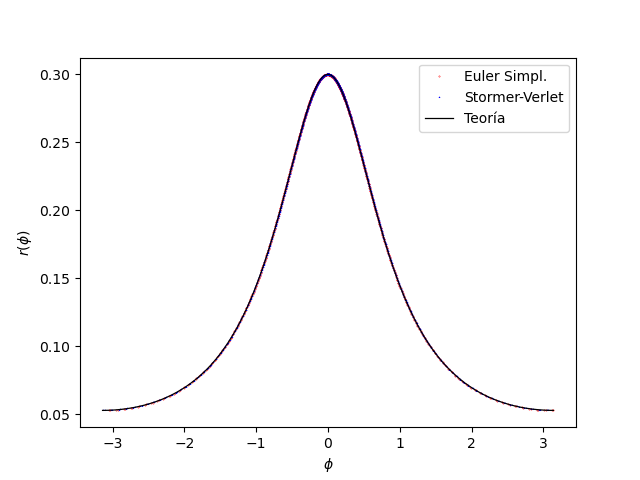

In [143]:
e = np.sqrt(1+2*E0*data_Pph[0]**2)
PHI = np.linspace(-np.pi,np.pi,1000)
R = (data_Pph[0]**2 )/(1 - e*np.cos(PHI))

plt.title
plt.plot(data_ph_e,data_r_e,'ro',markersize=0.3,label='Euler Simpl.')
plt.plot(data_ph, data_r,'bv',markersize=0.3,label='Stormer-Verlet')
plt.plot(PHI,R,'k-',lw=0.9,label='Teoría')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r(\phi)$')
plt.legend()

# Campos Vectoriales y Flujos

La visualización de los campos vectoriales Hamiltonianos para un problema de 3 dimensiones puede ser un poco complicada. El camino tomado consistió en considerar el campo vectorial $\mathbf{X_x}= p_x \frac{\partial}{\partial x} - \frac{x}{\left( x^2 + y^2 +z^2 \right)^{3/2}} \frac{\partial}{\partial p_x}$, que corresponde a la proyección del campo hamiltoniano solo sobre las coordenadas $x$ y $p_x$.

Para poder visualizar el flujo, se considera $a^2 = y^2 +z^2$, y se reemplaza su valor para cada parte del movimiento utilizando las soluciones ya encontradas. 

La animación que se muestra a continuación muestra el campo vectorial asociado en cada parte del movimiento. La partícula que se muestra corresponde a la solución encontrada para ese paso en específico. Las magnitudes del campo vectorial se muestran en la figura usando los colores, donde para definir estos se tomó el logaritmo natural de la magnitud. 

<IPython.core.display.Javascript object>


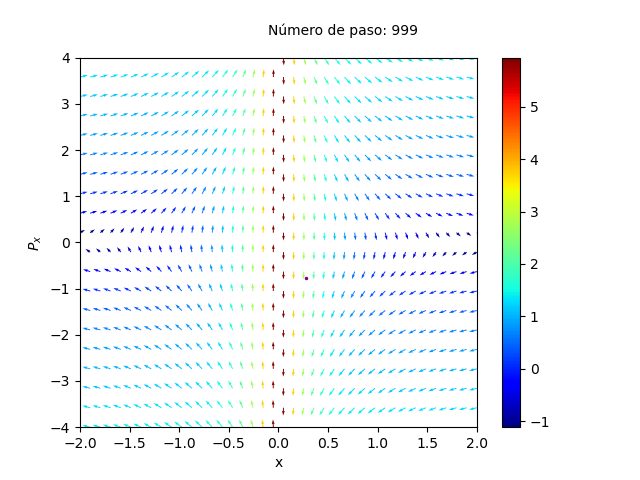

/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:21: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


In [161]:
from matplotlib import animation
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib notebook

A2 = data_y**2 + data_z**2

X, PX = np.meshgrid(np.linspace(-2,2,40),np.linspace(-4,4,20))
U = PX
V = -X/((X**2 + A2[0])**(3/2))


colormap = cm.rainbow
#
L=np.sqrt(U*U+V*V)
M = np.log(L)

fig, ax = plt.subplots(1,1)
Q = ax.quiver(X, PX, U/L, V/L,M, cmap=plt.cm.jet,pivot='tail')
plt.colorbar(Q, cmap=plt.cm.jet)
ax.set_xlim(-2, 2)
ax.set_ylim(-4, 4)

plt.xlabel(r'x')
plt.ylabel(r'$P_x$')

point, = ax.plot(data_x[0],data_px[0],marker=".", markersize=3, color="purple")

tx = ax.text(-0.1,4.5,'Número de paso: {}'.format(0))


def update_quiver(num, Q, X, PX):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """

    U = PX
    V = -X/(X**2 + A2[num])**(3/2) 
    
    # Normalize the arrows:
    U = U / np.sqrt(U*U+V*V)
    V = V / np.sqrt(U*U+V*V)
    
    point.set_data(data_x[num],data_px[num])
    tx.set_text('Número de paso: {}'.format(num))
    #plt.plot(data_x[num],data_px[num],marker="o", markersize=1, markeredgecolor="red", markerfacecolor="green")
    
    Q.set_UVC(U,V)
    
    return Q, point,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver ,fargs=(Q, X, PX),
                               interval=5 ,blit=False)


En general, el flujo encontrado sigue la forma general del campo. Se puede repetir el mismo procedimiento para la carta $\left( U , (r, \theta, \phi , P_r , P_{\theta}, P_{\Phi}) \right)$. En este caso se ilustra el campo hamiltoniano $\mathbf{X_r}= P_r \frac{\partial}{\partial r} + \frac{P^2_\phi}{r^3} - \frac{1}{r^2} \frac{\partial}{\partial P_r}$. Las condiciones iniciales planteadas son tales que $\theta = \pi$ y $P_\theta = 0$ (la órbita vive en el plano $xy$) , por lo cual la visualización de este campo vectorial si es constante en el tiempo.  

<IPython.core.display.Javascript object>


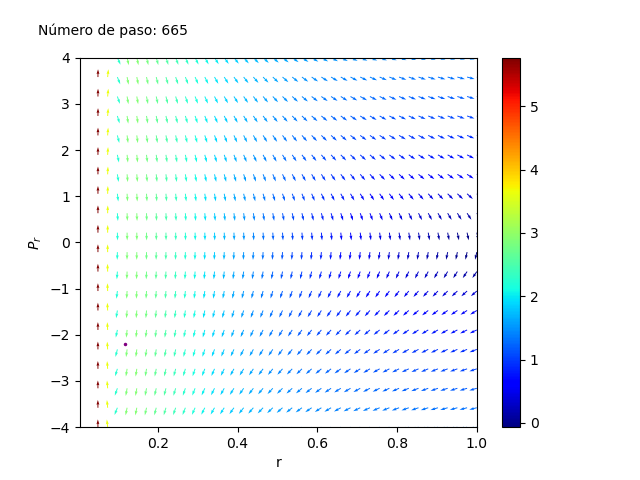

/opt/sagemath-9.2/local/lib/python3.7/site-packages/sage/repl/ipython_kernel/__main__.py:21: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


In [160]:
from matplotlib import animation
import matplotlib.cm as cm
from matplotlib.colors import Normalize

%matplotlib notebook

A2 = data_y**2 + data_z**2

R, PR = np.meshgrid(np.linspace(0.05,1,40),np.linspace(-4,4,20))
U = PR
V = data_Pph[0]**2/R**3 - 1/R**2


colormap = cm.rainbow
#
L=np.sqrt(U*U+V*V)
M = np.log(L)

fig, ax = plt.subplots(1,1)
Q = ax.quiver(R, PR, U/L, V/L,M, cmap=plt.cm.jet,pivot='tail')
plt.colorbar(Q, cmap=plt.cm.jet)
ax.set_xlim(0.005, 1)
ax.set_ylim(-4, 4)

plt.xlabel(r'r')
plt.ylabel(r'$P_r$')

point, = ax.plot(data_r[0],data_Pr[0],marker=".", markersize=3, color="purple")

tx = ax.text(-0.1,4.5,'Número de paso: {}'.format(0))


def update_quiver(num):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """

    point.set_data(data_r[num],data_Pr[num])
    tx.set_text('Número de paso: {}'.format(num))
    #plt.plot(data_x[num],data_px[num],marker="o", markersize=1, markeredgecolor="red", markerfacecolor="green")
    
    
    
    return point,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver ,
                               interval=5 ,blit=False)